# Tworzenie sieci neuronowej

W tym zadaniu stworzymy w pełni połączoną sieć neuronową przy użyciu niskopoziomowych mechanizmów tensorflow.

Architektura sieci neuronowej została przedstawiona na poniższym rysunku. Jak widać, ma ona jedną warstwę wejściową, dwie warstwy ukryte i warstwę wyjściową. W warstwach ukrytych wykorzystamy sigmoid jako funkcję aktywacji. Na warstwie wyjściowej użyjemy softmax.

Część kodu do utworzenia sieci została już napisana, musisz wypełnić puste miejsca w określonych miejscach.

## Architektura sieci neuronowej

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Informacje o zestawie danych MNIST

Będziemy trenować tę sieć neuronową na zbiorze danych MNIST. Ten zbiór danych to duża liczba odręcznych obrazów cyfr składających się z 28 razy 28 pikseli. Każdy piksel przyjmuje wartość od 0 do 255.

Tak jak poprzednio, zbiór danych zostanie podzielony na próbki treningowe i testowe. Znormalizujemy wszystkie obrazy tak, aby wartości pikseli wynosiły od 0 do 1, dzieląc jasność każdego piksela przez 255.

Ponadto architektura sieci neuronowej oczekuje wektora jako danych wejściowych. W naszym przypadku jednak każdy przykładowy obiekt jest macierzą. Co należy zrobić? W tym zadaniu "rozciągniemy" macierz 28 razy 28$, uzyskując w ten sposób wektor składający się z 784 elementów.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Więcej informacji na temat zbioru danych można znaleźć na stronie [tutaj](http://yann.lecun.com/exdb/mnist/).

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
num_classes = 10 # całkowita liczba klas, w naszym przypadku są to liczby od 0 do 9
num_features = 784 # liczba atrybutów wektora wejściowego 28 * 28 = 784

learning_rate = 0.001 # szybkość uczenia się sieci neuronowej
training_steps = 2500 # maksymalna liczba epok
batch_size = 256 # przeliczymy wagi sieci nie na całej próbce, ale na jej losowym podzbiorze elementów bat
display_step = 100 # co 100 iteracji pokażemy aktualną wartość funkcji straty i dokładności

n_hidden_1 = 128 # liczba neuronów warstwy 1
n_hidden_2 = 256 # liczba neuronów warstwy 2

In [4]:
from tensorflow.keras.datasets import mnist

# Ładowanie zestawu danych
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Konwersja pikseli całkowitych na typ float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Konwertujemy macierze 28x28 pikseli na wektor składający się z 784 elementów
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Normalizacja wartości pikseli
x_train, x_test = x_train / 255., x_test / 255.

# Zmiksujmy dane treningowe
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [5]:
# Stwórzmy sieć neuronową

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)

        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x):
        y = tf.matmul(x, self.w) + self.b
        return y

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)

    # Pierwsza warstwa, składająca się z 128 neuronów
    self.layer1 = DenseLayer(in_features=num_features, out_features=n_hidden_1)

    # Druga warstwa, składająca się z 256 neuronów
    self.layer2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2)

    # Warstwa wyjściowa
    self.out_layer = DenseLayer(in_features=n_hidden_2, out_features=num_classes)

  def __call__(self, x):

    # Pamiętaj, że do wyjścia sieci neuronowej stosujemy funkcję softmax.
    # Robimy to tak, aby
    # Wyjście sieci neuronowej przyjmuje wartości od 0 do 1 zgodnie z prawdopodobieństwem
    # prawdopodobieństwa przynależności obiektu wejściowego do jednej z 10 klas

    x = self.layer1(x)
    x = tf.nn.sigmoid(x)
    x = self.layer2(x)
    x = tf.nn.sigmoid(x)
    x = self.out_layer(x)
    return tf.nn.softmax(x)

In [6]:
# W tym przypadku wygodnie jest przyjąć entropię krzyżową jako funkcję błędu
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Obliczanie entropii krzyżowej
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Jako miernik jakości stosujemy dokładność
def accuracy(y_pred, y_true):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

In [7]:
# Stwórzmy przykładową sieć neuronową
neural_net = NN(name="mnist")

# Funkcja treningu sieci neuronowej
def train(nn, input_x, output_y):
  # Do dopasowania wag sieci wykorzystamy stochastyczne zejście gradientowe
  optimizer = tf.optimizers.SGD(learning_rate)

  # Aktywacja automatycznego różnicowania
  with tf.GradientTape() as g:
    pred = nn(input_x)
    loss = cross_entropy(pred, output_y)

    # Utwórz zoptymalizowaną listę parametrów
    trainable_variables = nn.trainable_variables

    # Oblicz na ich podstawie wartość gradientu
    gradients = g.gradient(loss, trainable_variables)

    # Zmodyfikuj parametry
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [8]:
# Szkolenie sieciowe

loss_history = []  # każdy krok display_step zapisuje bieżący błąd sieci neuronowej na tej liście
accuracy_history = [] # każdy krok display_step zapisuje aktualną dokładność sieci neuronowej na tej liście

# W tej pętli będziemy trenować sieć neuronową
# Z treningowego zbioru danych train_data, wyodrębnij losowy podzbiór, na którym
# będzie trenowana. Użyj metody take dostępnej dla szkoleniowego zbioru danych.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Aktualizacja wag sieci neuronowej
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        loss_history.append(loss)
        accuracy_history.append(acc)
        print(f"step: {step}, loss: {loss.numpy()}, accuracy: {acc.numpy()}")

step: 100, loss: 479.1614074707031, accuracy: 0.59375
step: 200, loss: 235.57138061523438, accuracy: 0.7265625
step: 300, loss: 185.08253479003906, accuracy: 0.80859375
step: 400, loss: 184.3346710205078, accuracy: 0.8125
step: 500, loss: 145.2270050048828, accuracy: 0.8203125
step: 600, loss: 101.79661560058594, accuracy: 0.875
step: 700, loss: 130.15274047851562, accuracy: 0.8515625
step: 800, loss: 114.97756958007812, accuracy: 0.86328125
step: 900, loss: 108.7331771850586, accuracy: 0.87890625
step: 1000, loss: 131.19837951660156, accuracy: 0.8515625
step: 1100, loss: 110.57144927978516, accuracy: 0.89453125
step: 1200, loss: 89.7239761352539, accuracy: 0.8984375
step: 1300, loss: 93.9019546508789, accuracy: 0.88671875
step: 1400, loss: 101.10598754882812, accuracy: 0.89453125
step: 1500, loss: 96.77877807617188, accuracy: 0.89453125
step: 1600, loss: 88.05323791503906, accuracy: 0.88671875
step: 1700, loss: 65.20696258544922, accuracy: 0.92578125
step: 1800, loss: 86.0212631225586

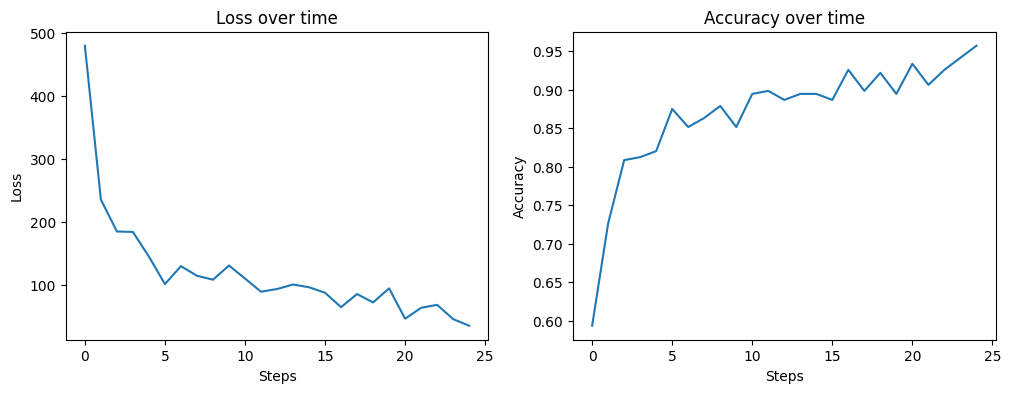

In [9]:
# Wykreśl zmianę dokładności i strat jako funkcję skoku
# Jeśli zostanie to zrobione poprawnie, dokładność powinna wzrosnąć, a straty powinny się zmniejszyć.

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(len(loss_history)), loss_history)
plt.title("Loss over time")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.subplot(1, 2, 2)
plt.plot(range(len(accuracy_history)), accuracy_history)
plt.title("Accuracy over time")
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.show()

In [10]:
# Oblicz dokładność wytrenowanej sieci neuronowej

pred = neural_net(x_test)
test_acc = accuracy(pred, y_test)
print(f"Test Accuracy: {test_acc.numpy()}")

Test Accuracy: 0.9014999866485596


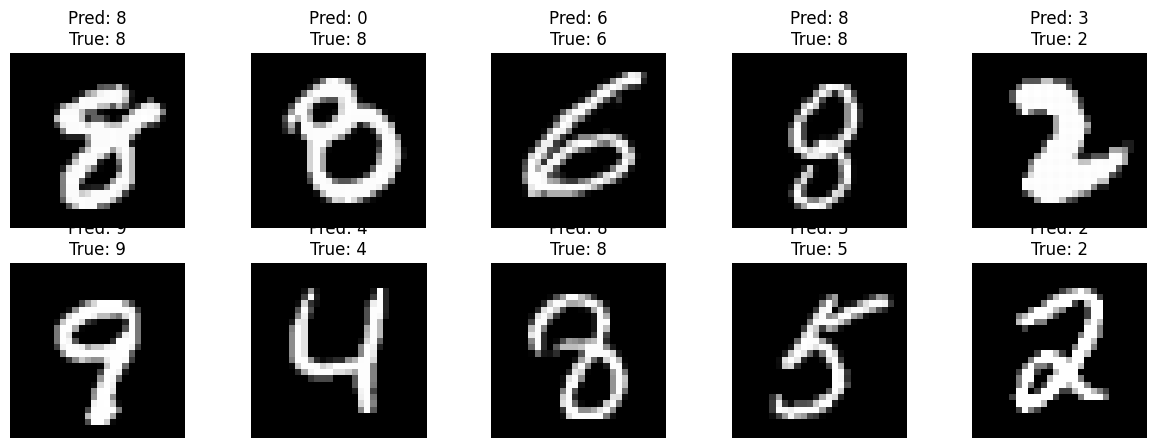

In [18]:
# Przetestuj wytrenowaną sieć neuronową na 10 obrazach. Z próbki testowej wybierz 5
# losowych obrazów i wprowadź je do sieci neuronowej.
# Wyprowadź obraz i zapisz obok niego odpowiedź sieci neuronowej.
# Czy sieć neuronowa się myli, a jeśli tak, to jak często?

idxs = np.random.choice(len(x_test), 10)
samples = x_test[idxs]
labels = y_test[idxs]

predictions = neural_net(samples)

plt.figure(figsize=(15, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(samples[i].reshape(28, 28), cmap='gray')
    plt.title(f"Pred: {np.argmax(predictions[i])}\nTrue: {labels[i]}")
    plt.axis('off')
plt.show()

Wyuczona sieć ma accuracy 0.9 na bazie testowej, co oznacza że myli się średnio w co 10 obrazku.